# Affinity Water Test


In [10]:
# Import necessary packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Access the data from the affinity water test link that has been downloaded into a .csv file using pandas df.


In [64]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Affinity_Water_Night_flow_Monitoring.csv')
print(df.columns)

# Generate summary statistics
summary_stats = df.describe()
print(summary_stats)

Index(['DATA_SOURCE', 'DATETIME_STAMP', 'DMA_ID', 'CENTROID_X', 'CENTROID_Y',
       'ACTUAL_MIN_NIGHT_FLOW', 'MIN_NIGHT_FLOW', 'UNITS', 'ObjectId'],
      dtype='object')
          CENTROID_X     CENTROID_Y  ACTUAL_MIN_NIGHT_FLOW  MIN_NIGHT_FLOW  \
count  974934.000000  974934.000000          974860.000000   974934.000000   
mean       -0.184905      51.647583               3.401128        3.687776   
std         0.481438       0.217169               2.917558        3.106399   
min        -0.769312      50.931029             -28.090000        0.000000   
25%        -0.456611      51.538072               1.533330        1.702778   
50%        -0.360623      51.653081               2.720000        2.955556   
75%        -0.172561      51.804979               4.411110        4.744444   
max         1.387540      52.071938              86.433330      134.638889   

            ObjectId  
count  974934.000000  
mean   487467.500000  
std    281439.348009  
min         1.000000  
25%    243

### Initial insights from raw data
There are only 2 columns within this dataset that jump out to me here in terms of raw data interpretation from the summary statsitics alone: ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW. 

- In the ACTUAL_MIN_NIGHT_FLOW column, we see that the minimum values are in the negatives, which really doesn't make sense as water flow should be detailed in positive values only (i.e. we can't have negative water flow).
- There’s a significant discrepancy between the min and max values in both ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW columns, indicating potential outliers or data entry errors. The comparison between the actual flow and the expected (minimum) flow could provide useful insights into inefficiencies, leaks, or anomalies within the water distribution network.

The statistics given for the rest make sense, as there are no large outliers and the min and max values make sense in the context of their descriptions.

I want to explore more into not only the flow rate, but also the flow rate with respect to the centroid values, as we can determine if the unexpected and faulty flow rates are specific to certain areas.

### Diving into the data

In [49]:
# save the interesting columns into dfs to plot and analyze
actual_min_flow = df['ACTUAL_MIN_NIGHT_FLOW']
min_night_flow = df['MIN_NIGHT_FLOW']
x_coords = df['CENTROID_X']
y_coords = df['CENTROID_Y']

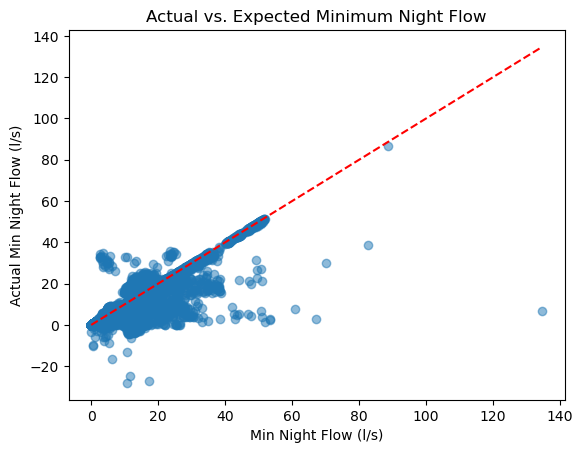

In [50]:
plt.scatter(df['MIN_NIGHT_FLOW'], df['ACTUAL_MIN_NIGHT_FLOW'], alpha=0.5)
plt.plot([0, max(df['MIN_NIGHT_FLOW'])], [0, max(df['MIN_NIGHT_FLOW'])], color='red', linestyle='--')
plt.xlabel('Min Night Flow (l/s)')
plt.ylabel('Actual Min Night Flow (l/s)')
plt.title('Actual vs. Expected Minimum Night Flow')
plt.show()

We can assess how well the actual flow aligns with the expected flow. Points that fall far from the 1:1 line (i.e., where ACTUAL_MIN_NIGHT_FLOW ≈ MIN_NIGHT_FLOW) highlight significant deviations, which could indicate operational inefficiencies or potential anomalies. Based, on our findings, we can see that a decent amount of our data does not align linearly.

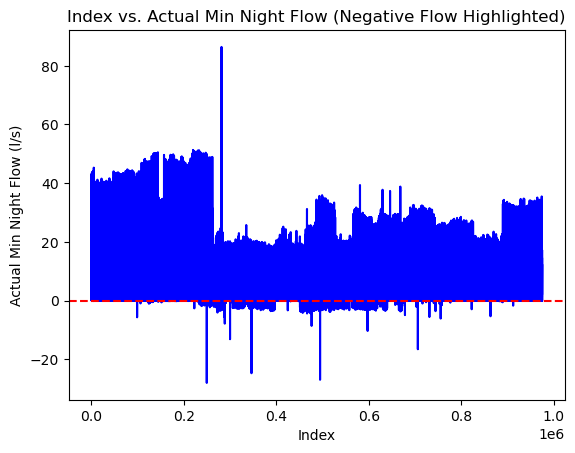

In [43]:
plt.plot(df.index, df['ACTUAL_MIN_NIGHT_FLOW'], color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Actual Min Night Flow (l/s)')
plt.title('Index vs. Actual Min Night Flow (Negative Flow Highlighted)')
plt.show()

In [51]:
# Count the number of times that the values for both are in the negative
# Set the threshold to be 0 so we can find the number of times the values are in the negative
threshold = 0

# Count the number of times ACTUAL_MIN_NIGHT_FLOW goes below the threshold
negative_count_actual_flow = (df['ACTUAL_MIN_NIGHT_FLOW'] < threshold).sum()
print(f"The number of times ACTUAL_MIN_NIGHT_FLOW is below {threshold}: {negative_count_actual_flow}")

The number of times ACTUAL_MIN_NIGHT_FLOW is below 0: 605


We see that there are a significant amount of cases in which the flow of the water is negative. The number of times that the ACTUAL_MIN_NIGHT_FLOW value is negative is 605.

In [54]:
# I want to make a df in which we only include the rows of data in which the ACTUAL_MIN_NIGHT_FLOW values are in the negative.
negative_flow_df = df[df['ACTUAL_MIN_NIGHT_FLOW'] < 0]

I want to see where these negative flow areas are occurring. By overlaying the DMAs with negative flow values on top of all the DMAs, we can see if there's a concentration of negative values in certain geographical areas.

The clusters of negative areas might indicate a regional issue (such as faulty sensors or data collection errors in that specific area).

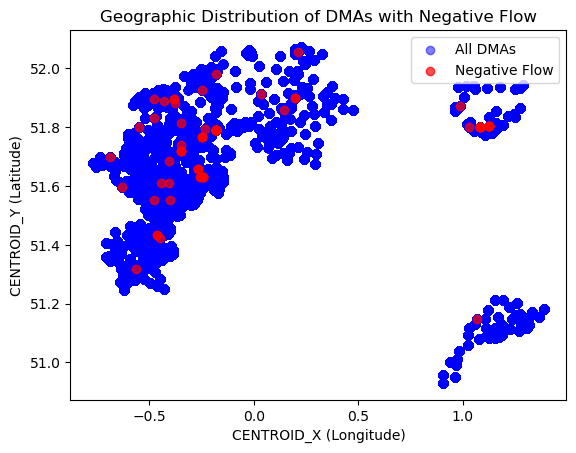

In [55]:
plt.scatter(x_coords, y_coords, color='blue', alpha=0.5, label='All DMAs')

# Overlay locations with negative ACTUAL_MIN_NIGHT_FLOW
plt.scatter(negative_flow_df['CENTROID_X'], negative_flow_df['CENTROID_Y'], color='red', label='Negative Flow', alpha=0.7)

# Adding labels and title
plt.title('Geographic Distribution of DMAs with Negative Flow')
plt.xlabel('CENTROID_X (Longitude)')
plt.ylabel('CENTROID_Y (Latitude)')
plt.legend()

# Display the plot
plt.show()

I want to see this data in number form rather than just visualization:

I want to group the negative flow df by the unique combinations of CENTROID_X and CENTROID_Y, count the number of occurrences (i.e., the number of rows) within each group, convert the grouped result back into a df (where the grouped coordinates become columns and thecount of occurrences is stored in a new column named count), and reset the index so that the grouped coordinates (CENTROID_X, CENTROID_Y) are represented as regular columns in the resulting df, instead of being part of the index.

In [62]:
# Count negative flow DMAs by ranges of CENTROID_X and CENTROID_Y
region_counts = negative_flow_df.groupby(['CENTROID_X', 'CENTROID_Y']).size().reset_index(name='count')

print(region_counts)

    CENTROID_X  CENTROID_Y  count
0    -0.687034   51.697214      1
1    -0.629787   51.595427      1
2    -0.565792   51.317391      1
3    -0.547613   51.799922      1
4    -0.478517   51.895680      1
5    -0.476174   51.828928      1
6    -0.475919   51.550993      1
7    -0.465126   51.433047      2
8    -0.449379   51.423929      1
9    -0.445751   51.607755      1
10   -0.428373   51.888397      1
11   -0.405881   51.684872      1
12   -0.403817   51.609965      1
13   -0.402673   51.552864      1
14   -0.380053   51.895651      2
15   -0.374707   51.879949      1
16   -0.349012   51.738657      1
17   -0.348025   51.719589      4
18   -0.347304   51.813650      1
19   -0.266836   51.658395      3
20   -0.259498   51.630075      2
21   -0.248887   51.926455      1
22   -0.248665   51.764856      5
23   -0.242430   51.628997      4
24   -0.234784   51.793768      1
25   -0.181885   51.978581      1
26   -0.180141   51.790225    516
27    0.036301   51.910824      1
28    0.143350

There are 2 distinct indices in which we know there are real issues. The rest of the indices have between 1 and 8 negatives value occurreences. Instead of setting a strict threshold of 8+ occurrences, I'll just say that:
- Low Priority (1–2 occurrences): Likely isolated incidents, monitor but not critical.
- Medium Priority (3–7 occurrences): Worth investigating, especially if there are other nearby DMAs with similar patterns. This could be an early warning sign of a developing issue.
- High Priority (8+ occurrences): Persistent issue, immediate investigation needed. This suggests a deeper systematic problem that could be affecting operational efficiency.

The visualization for the above is shown below so we can see where exactly our priorities lie:

In [63]:
# Define thresholds for different priority levels
low_priority = region_counts[region_counts['count'] <= 2]
medium_priority = region_counts[(region_counts['count'] >= 3) & (region_counts['count'] <= 7)]
high_priority = region_counts[region_counts['count'] >= 8]

# Display high-priority regions
print("High Priority (8+ occurrences):")
print(high_priority)

print("\nMedium Priority (3-7 occurrences):")
print(medium_priority)

High Priority (8+ occurrences):
    CENTROID_X  CENTROID_Y  count
26   -0.180141   51.790225    516
34    1.083000   51.799532     32
35    1.125741   51.803280      8

Medium Priority (3-7 occurrences):
    CENTROID_X  CENTROID_Y  count
17   -0.348025   51.719589      4
19   -0.266836   51.658395      3
22   -0.248665   51.764856      5
23   -0.242430   51.628997      4


I want to see exactly where the high priority regions are located (visually) in red so we can determine what's going on there. I'll also include the medium priority areas in orange.

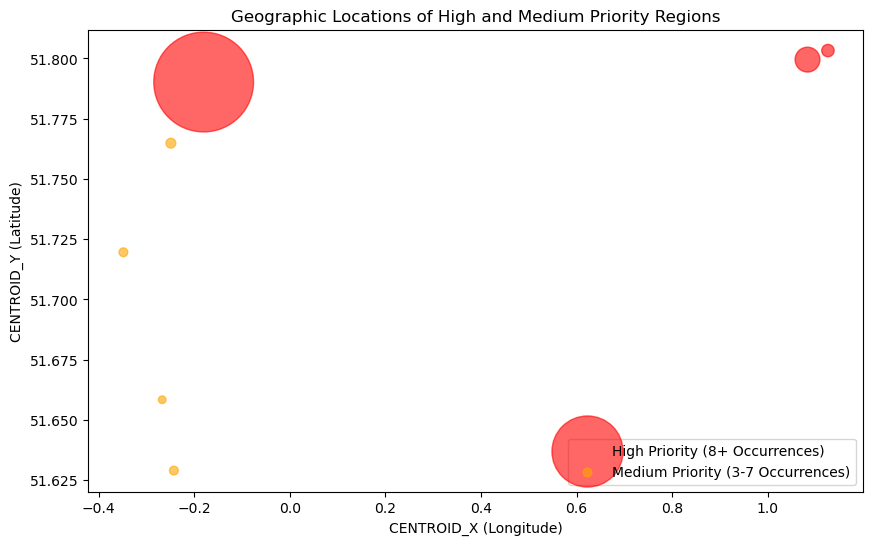

In [69]:
# Correct data for high-priority regions (3 points)
high_priority = {
    'CENTROID_X': [-0.180141, 1.083000, 1.125741],
    'CENTROID_Y': [51.790225, 51.799532, 51.803280],
    'count': [516, 32, 8]
}

# Correct data for medium-priority regions (4 points)
medium_priority = {
    'CENTROID_X': [-0.348025, -0.266836, -0.248665, -0.242430],
    'CENTROID_Y': [51.719589, 51.658395, 51.764856, 51.628997],
    'count': [4, 3, 5, 4]
}

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot high-priority regions in red
plt.scatter(high_priority['CENTROID_X'], high_priority['CENTROID_Y'], 
            color='red', s=[c * 10 for c in high_priority['count']], 
            label='High Priority (8+ Occurrences)', alpha=0.6)

# Plot medium-priority regions in yellow
plt.scatter(medium_priority['CENTROID_X'], medium_priority['CENTROID_Y'], 
            color='orange', s=[c * 10 for c in medium_priority['count']], 
            label='Medium Priority (3-7 Occurrences)', alpha=0.6)

# Add labels and title
plt.xlabel('CENTROID_X (Longitude)')
plt.ylabel('CENTROID_Y (Latitude)')
plt.title('Geographic Locations of High and Medium Priority Regions')
plt.legend()

# Show the plot
plt.show()

The above now gives us an idea of where the high and medium priority sources are located. I believe the two red circles on the top left are close geographically but represent distinct DMAs with slightly different centroid coordinates. 

### Insights Gained

Maybe i want to determine where the coordinates are when we see negative flow in the ACTUAL_MIN_NIGHT_FLOW data? 
Maybe i want to determine why theres a discrepancy in the ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW?